<a href="https://colab.research.google.com/github/grmounica/Data-Structures-and-Algorithms/blob/main/Hackathon3_Face_Similarity_and_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

In [ ]:
#@title Explanation Video
from IPython.display import HTML

HTML("""<video width="500" height="300" controls>
  <source src="https://cdn.talentsprint.com/aiml/AIML_BATCH_HYD_7/Apr15/HackathonTaskArchitecture.mp4" type="video/mp4">
</video>
""")

### Setup Steps

In [ ]:
#@title Run this cell to complete the setup for this Notebook

from IPython import get_ipython
ipython = get_ipython()
  
notebook="M3_Hackathon" #name of the notebook

def setup():
   # ipython.magic("sx pip3 install torch")
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/FaceRecogHackathon/Datasets/ATandT/data-20190607T005435Z-001.zip")
    ipython.magic("sx unzip data-20190607T005435Z-001.zip")
    
    ipython.magic("sx pip install torch==1.0.1 -f https://download.pytorch.org/whl/cu100/stable")
    ipython.magic("sx pip install torchvision==0.2.1")
    ipython.magic("sx pip install opencv-python")
    print ("Setup completed successfully")
    return
setup()

Setup completed successfully


# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports: All the imports are defined here

We are downgrading the packages and installing the packages as defined below to compatible with the server.

torch = 1.0.1

torchvision = 0.2.1

PIL = 5.3.0

* When you run the below code for uninstalling and downgrading the PIL version, you will get a button "Restart Runtime" below. 

* Just click on the "Restart Runtime" and select "Yes" when it prompts. This Restart runtime will only reset the PIL package. 

NOTE: **DONOT** GO TO RUNTIME  -> RESTART RUNTIME. This will restart all packages then you need to repeat all the steps from begining.

* Simply continue with the next code cell 



In [ ]:
!pip uninstall -y Pillow

Uninstalling Pillow-7.0.0:
  Successfully uninstalled Pillow-7.0.0


In [ ]:
# IGNORE ERROR. Click on Restart Runtime button and proceed with the next code cell.
!pip install Pillow==5.3.0

     |████████████████████████████████| 2.0MB 5.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
# When you run this, it should give you pil version = 5.3.0
import PIL
print(PIL.__version__)

5.3.0


## Downloaded Dataset:

During the setup you have downloaded this data:

* **AT&T Dataset** (named as data): (During the setup, downloaded the folder,  data-20190607T005435Z-001)
> * There are 10 images each of 40 different classes (people)


In [ ]:
%ls

data/  data-20190607T005435Z-001.zip  sample_data/


## Stage1A: Activate the Server Access and collect the Team Data (This can be done on the day of the Hackathon once the login username and password given)

Activate the Server Acces
* Open the terminal (Command Prompt)
* Login to SSH by typing **ssh (username)@aiml-sandbox1.talentsprint.com**. Give the login username which is given to you. 

`Eg: ssh b12h3gxx@aiml-sandbox1.talentsprint.com`

  (If it is your first time connecting to the server from this computer, accept the connection by typing "yes".)
* After logging into SSH, please activate your virtual environment using the
command **source venv/bin/activate** and then press enter
* You can start the server by giving the command **sh runserver.sh** and then press enter.
* In order to collect team data in mobile app, ensure the server is active


Team Data Collection

* Follow the "Mobile_APP_Documentation" to collect the Faces of your team. These will be stored in the server to which login is provided to you.

[Mobile_APP_Documentation](https://drive.google.com/file/d/1bn9BzjEZ6qHKCUA_oWFsEN-cx27VHe_y/view?usp=sharing)


##Stage 2A (Face Similarity and Recognition): (20 marks) 

* Define and train Siamese network.

* Test the trained model with load_state_dict

* Load your team data and get a siamese representation of your images. 

* Now train a classifier (use any classifier) with the features extracted from the above trained Siamese network of your team data. 

* Save the Classification using the below:
     * For simple MLP with Pytorch, use state dictionary. It will be useful in integrating to the mobile app.

      OR

     * For Sklearn classification, use Joblib.

* Download the trained models (Siamese model, Classification model) and upload them in the ftp server (refer to [Filezilla Installation and Configuration document](https://drive.google.com/file/d/1dwvGkVavwqNSTvcNet6-4sL0qqw2P5sU/view?usp=sharing)).

* Update the “face_recognition.py” file in the server by providing the code for predicting the face and to get similarity measure.(Note: To define the architecture of your trained model, you'll need to define it in the file "face_recognition_model.py")

* Test your model on the mobile app for Face similarity and Face recognition. Also you can see the results in your terminal(Command prompt).

* **Grading Scheme:**


> * Face Similarity (10M): Using the mobile app’s “Face Similarity” functionality, the face similarity gives the distance between the pair images. If the similarity measure between the two images is less, it means both pairs are similar. If the similarity measure between the two images is more, it means both pairs are dissimilar


> * Face Recognition (10M): Recognize the person correctly using the mobile app’s “Face Recognition” functionality

##Import libraries

In [ ]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Define and Train Siamese Network

**Configuration Class**

A simple class to manage configuration

**Siamese with Faces dataset one-shot**

In [ ]:

class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

**Display a sample image**

(112, 92, 3)


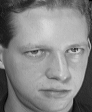

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

im1 = cv2.imread('./data/faces/training/s1/10.pgm')
print(im1.shape)
cv2_imshow(im1)

**Custom Dataset Class**
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [ ]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

**Using Image Folder Dataset**

In [ ]:
# Create imageFolder dataset 
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [ ]:
#Create SiameseNetworkDataset (defined earlier in this notebook); chiefly the data retriever (get_item) is overriden to
#..provide pair of images + similar/dissimilar label. 
#NOTE: the TRANSFORMS HERE CONSISTS OF a) resizing to 100*100 b) Converting to tensor.YOU HAVE TO APPLY SAME..
#..TRANSORMS WHEN DEPLOYING THE MODEL ON THE SERVER!! 
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

In [ ]:
# Nonechucks is not needed for this dataset. But in cases where you dataloader gives image not found error i.e.
#..in cases where image is malformed, nonechucks helps in eliminating those images so that your dataloader doesn't fail.
# So good practise to use this code below
!pip install Nonechucks
import nonechucks as nc

In [ ]:
siamese_dataset = nc.SafeDataset(siamese_dataset)

In [ ]:
siamese_dataset

**Visualising some of the data**
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

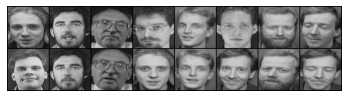

[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

**Neural Net Definition**

We will use a standard convolutional neural network

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))
    # This is for one image. This can be used while classifying the faces images
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
   
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

**Contrastive Loss**

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

**Training the model**

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
%%capture
for epoch in range(0,Config.train_number_epochs):
   
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter,loss_history)

In [ ]:
## Saving the model as a state dictionary
state = {
    'net_dict': net.state_dict()
}


torch.save(state, './siamese_model.t7')

## Testing with load_state_dict

In [ ]:
myModel = SiameseNetwork().cuda()

In [ ]:
%ls

captured_face_images/  data-20190607T005435Z-001.zip  siamese_model.t7
data/                  sample_data/


In [ ]:
ckpt = torch.load('./siamese_model.t7')

In [ ]:
#Save the state dictionary of the Siamese network (use pytorch only), It will be useful in integrating to the mobile app
myModel.load_state_dict(ckpt['net_dict'])

The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

<class 'torch.Tensor'> torch.Size([1, 1, 100, 100])


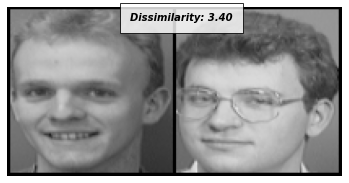

<class 'torch.Tensor'> torch.Size([1, 1, 100, 100])


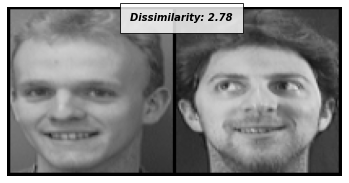

<class 'torch.Tensor'> torch.Size([1, 1, 100, 100])


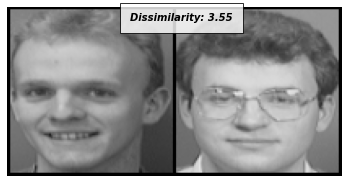

<class 'torch.Tensor'> torch.Size([1, 1, 100, 100])


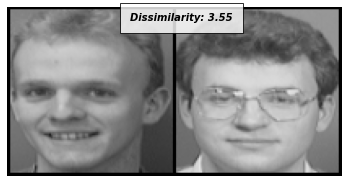

<class 'torch.Tensor'> torch.Size([1, 1, 100, 100])


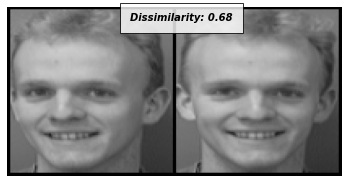

<class 'torch.Tensor'> torch.Size([1, 1, 100, 100])


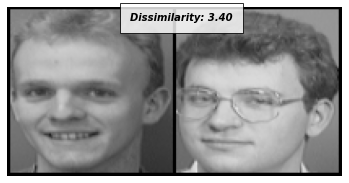

<class 'torch.Tensor'> torch.Size([1, 1, 100, 100])


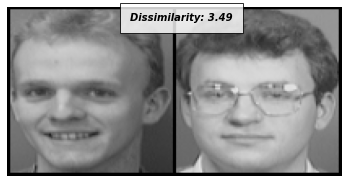

<class 'torch.Tensor'> torch.Size([1, 1, 100, 100])


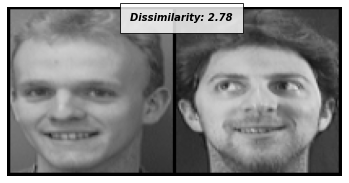

<class 'torch.Tensor'> torch.Size([1, 1, 100, 100])


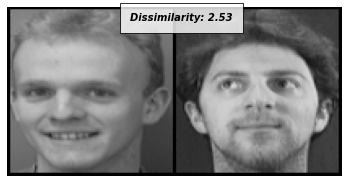

<class 'torch.Tensor'> torch.Size([1, 1, 100, 100])


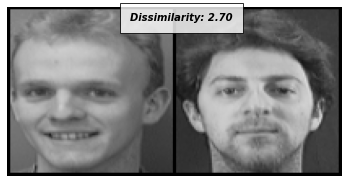

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir) #testing_dir
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

siamese_dataset = nc.SafeDataset(siamese_dataset)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    print(type(x0),x0.shape)
    
    output1,output2 = myModel(Variable(x0).cuda(),Variable(x1).cuda()) #using the loaded 'myModel'; even 'net' can be used
    #..but using 'myModel' helps a quick test on if the save and load model is working fine. You will replicate the same
    #..in the server.

    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

## Load your team data and get a Siamese representation of your images.

**Download your team data into your colab notebook using the links provided below.**

NOTE: Replace the string "username" with your login username (such as b12h3gxx) in the cell below for face images. 

This data will be useful while training the networks.

In [ ]:
!wget -nH --recursive --no-parent --reject 'index.*' https://aiml-sandbox.talentsprint.com/expression_detection/b12h3g14/captured_face_images/ --cut-dirs=3  -P ./captured_face_images

--2020-04-23 16:58:36--  https://aiml-sandbox.talentsprint.com/expression_detection/b12h3g14/captured_face_images/
Resolving aiml-sandbox.talentsprint.com (aiml-sandbox.talentsprint.com)... 139.162.203.12
Connecting to aiml-sandbox.talentsprint.com (aiml-sandbox.talentsprint.com)|139.162.203.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘./captured_face_images/index.html.tmp’

index.html.tmp          [ <=>                ]     808  --.-KB/s    in 0s      

2020-04-23 16:58:36 (99.2 MB/s) - ‘./captured_face_images/index.html.tmp’ saved [808]

Loading robots.txt; please ignore errors.
--2020-04-23 16:58:36--  https://aiml-sandbox.talentsprint.com/robots.txt
Reusing existing connection to aiml-sandbox.talentsprint.com:443.
HTTP request sent, awaiting response... 404 Not Found
2020-04-23 16:58:36 ERROR 404: Not Found.

Removing ./captured_face_images/index.html.tmp since it should be rejected.

--2020-04-23 16:58:36--  https

In [ ]:
#Here simple ImageFolder is enough; we don't need SiameseDataSet 
finalClassifierDset = dset.ImageFolder(root='./captured_face_images',transform = 
                                       transforms.Compose([transforms.Grayscale(num_output_channels = 1)
                                                           ,transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]))

In [ ]:
#Dataloader using the dataset created above.
representation_dataloader = DataLoader(finalClassifierDset,
                        shuffle=False,
                        num_workers=8,
                        batch_size=10)

In [ ]:
###Load the state dict of the siamese model 
#<YOUR CODE HERE>
team_siamese = torch.load('./siamese_model.t7')

In [ ]:
team_model=SiameseNetwork().cuda()

In [ ]:
team_model.load_state_dict(team_siamese['net_dict'])

In [ ]:
##Get a siamese representation of each of your data points i.e. each of your images.
##For example(if your image is of the size 124*124 above)
#<YOUR CODE HERE>

dataiter_team = iter(representation_dataloader)
t0,_= next(dataiter_team)

for i in range(10):
    t1,_ = next(dataiter_team)
    concatenated = torch.cat((t0.float(),t1.float()),0)
    print(type(t0),t0.shape)
    
    output1,output2 = team_model(Variable(t0).cuda(),Variable(t1).cuda()) #using the loaded 'myModel'; even 'net' can be used
    #..but using 'myModel' helps a quick test on if the save and load model is working fine. You will replicate the same
    #..in the server.

    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

StopIteration: ignored

In [ ]:

for x,y in representation_dataloader:
  x_train = team_model.forward_once(x.cuda())
  x_train= x_train.cpu().detach().numpy()
  y_train = y.numpy()
  y_train

## Now train a classifier (use any classifier) with the features extracted from the above trained Siamese network of your team data. However you have to convert torch variable to numpy array before using SkLearn.

In [ ]:
# YOUR CODE HERE for training a classifier. You can use simple MLP with Pytorch or Sklearn model. 
# Note: Ensure you convert torch variable to numpy array before using SkLearn.

In [ ]:
from sklearn.svm import SVC
clf1 = SVC(kernel = 'rbf', C = 1E6)
clf1.fit(x_train, y_train)

SVC(C=1000000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
output=clf1.predict(x_train)

In [ ]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(clf1.predict(x_train),y_train)

0.9

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k = 3
neigh = KNeighborsClassifier(n_neighbors=k,metric="euclidean")

In [ ]:
neigh.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
acc=neigh.score(x_train,y_train)

In [ ]:
acc

0.8181818181818182

In [ ]:
from sklearn.neural_network import MLPClassifier
clf_mlp=MLPClassifier(hidden_layer_sizes=(101,101,100))
clf_mlp.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(101, 101, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
accuracy_score(clf_mlp.predict(x_train),y_train)

1.0

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(100*100, 1000)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1000, 100)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(100,50)
        self.fc4 = nn.Linear(50,5)
        

    def forward(self, x):
        x = x.view(-1, 100*100)
        x = F.relu(self.fc1(x))#Why do we sometimes use F. and sometimes nn.? You could refere the following link: https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-vs-f-relu/27599
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        x = self.fc3(x)
        return F.log_softmax(self.fc4(x), dim=1)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
model = Net()
model = model.to(device)

In [ ]:
model

Net(
  (fc1): Linear(in_features=10000, out_features=1000, bias=True)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc2_drop): Dropout(p=0.2)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=5, bias=True)
)

In [ ]:
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

In [ ]:
epochs=20

for epoch in range(epochs):
  model.train()
  lossv,accv=[],[]
  correct=0
  total_samples=0
  for batch_idx,(data, target) in enumerate(representation_dataloader):
    data, target = data.cuda(), target.cuda()
    print(data.size(0))
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    print(output.size(0))
    loss.backward()
    optimizer.step()
    _,predicted=torch.max(output,1)
    #print("predicted",predicted)
    print("predicted and target",(predicted==target).sum().item())
    correct+=(predicted==target).sum().item()
        #print("correct",correct)
    #print("correct",correct)
    #print("target size",target.size(0))
    total_samples+=target.size(0)
        #print("total samples", total_samples)
  accv.append((correct/total_samples))
  print(correct)  
  print(total_samples)
  print('Training Accuracy:{:.3f}\tLoss: {:.6f}'.format(accv[-1], loss.item()))

10
10
predicted and target 10
10
10
predicted and target 0
10
10
predicted and target 0
10
10
predicted and target 0
10
10
predicted and target 0
10
50
Training Accuracy:0.200	Loss: 1.592183
10
10
predicted and target 10
10
10
predicted and target 0
10
10
predicted and target 0
10
10
predicted and target 0
10
10
predicted and target 0
10
50
Training Accuracy:0.200	Loss: 1.598396
10
10
predicted and target 10
10
10
predicted and target 0
10
10
predicted and target 0
10
10
predicted and target 0
10
10
predicted and target 0
10
50
Training Accuracy:0.200	Loss: 1.595321
10
10
predicted and target 10
10
10
predicted and target 0
10
10
predicted and target 0
10
10
predicted and target 0
10
10
predicted and target 0
10
50
Training Accuracy:0.200	Loss: 1.600549
10
10
predicted and target 10
10
10
predicted and target 0
10
10
predicted and target 0
10
10
predicted and target 0
10
10
predicted and target 0
10
50
Training Accuracy:0.200	Loss: 1.590410
10
10
predicted and target 10
10
10
predicted

In [ ]:
epochs = 50

lossv, accv = [], []
for epoch in range(1, epochs +
                   1):
    train(epoch)

correct 0
total samples 50
Train Epoch: 1 Training Accuracy:0.000	Loss: 3.920492
correct 0
total samples 50
Train Epoch: 2 Training Accuracy:0.000	Loss: 3.921336
correct 1
total samples 50
Train Epoch: 3 Training Accuracy:0.020	Loss: 3.921123
correct 4
total samples 50
Train Epoch: 4 Training Accuracy:0.080	Loss: 3.911474
correct 0
total samples 50
Train Epoch: 5 Training Accuracy:0.000	Loss: 3.932069
correct 0
total samples 50
Train Epoch: 6 Training Accuracy:0.000	Loss: 3.915281
correct 1
total samples 50
Train Epoch: 7 Training Accuracy:0.020	Loss: 3.917875
correct 2
total samples 50
Train Epoch: 8 Training Accuracy:0.040	Loss: 3.909055
correct 1
total samples 50
Train Epoch: 9 Training Accuracy:0.020	Loss: 3.923542
correct 2
total samples 50
Train Epoch: 10 Training Accuracy:0.040	Loss: 3.912034
correct 0
total samples 50
Train Epoch: 11 Training Accuracy:0.000	Loss: 3.922167
correct 0
total samples 50
Train Epoch: 12 Training Accuracy:0.000	Loss: 3.922421
correct 0
total samples 5

## Save your classification model

* Save using state dictionary for simple MLP with Pytorch, otherwise use joblib for SKlearn model.

[Hint](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [ ]:
# YOUR CODE HERE for saving the model. 
#Note: if you use simple MLP with Pytorch, then use state-dict for saving the model. Otherwise for SkLearn classifier use joblib for saving the model.
import joblib

filename="svmclassifer.sav"
joblib.dump(clf1,filename)

['svmclassifer.sav']

In [ ]:
test = joblib.load(filename)

In [ ]:
test.predict(x_train)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

## Download your trained model using the code below
* Given the path of model file the following code downloads it through the browser

In [ ]:
from google.colab import files
files.download('<model_file_path>')